In [1]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData

from matplotlib.colors import LogNorm

from IPython.display import display, Markdown

import inspect
import importlib
import warnings
warnings.filterwarnings('ignore')

# Plot setup
matplotlib.rc('font', size=22, family='normal', weight='bold')
plt.rcParams['figure.figsize'] = [10, 8]
np.printoptions(suppress=True)

# Lots of functions piped from Bernstein's C code:

In [2]:
'''Here are some functions piped from Bernstein's transform.c, part of orbfit'''

ECL = np.radians(23.43928)

def check_latlon0(lat0, lon0):
    '''
    This function is adapted from Bernstein's transform.c, part of orbfit.
    It doesn't actually check anything here, just calculates all the sines and cosines.
    '''
    clat0 = np.cos(lat0)
    slat0 = np.sin(lat0)
    clon0 = np.cos(lon0)
    slon0 = np.sin(lon0)
    
    return clat0, slat0, clon0, slon0

def ec_to_proj(lat_ec, lon_ec, lat0, lon0):
    '''
    First routine goes from ecliptic lat/lon to projected x/y angles
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)
    cdlon = np.cos(lon_ec - lon0)
    sdlon = np.sin(lon_ec - lon0)
    clat  = np.cos(lat_ec)
    slat  = np.sin(lat_ec)

    xp = clat * sdlon
    yp = clat0*slat - slat0*clat*cdlon
    zp = slat0*slat + clat0*clat*cdlon

    x_proj = xp/zp
    y_proj = yp/zp

    return x_proj, y_proj


def proj_to_ec(x_proj, y_proj, lat0, lon0):
    '''
    Now the inverse, from projected xy to ecliptic lat/lon
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    zp = 1./np.sqrt(1 + x_proj*x_proj + y_proj*y_proj)
    lat_ec = np.arcsin( zp* (slat0 + y_proj*clat0) )
    lon_ec = lon0 + np.arcsin( x_proj * zp / np.cos(lat_ec) )

    return lat_ec, lon_ec

def xyz_ec_to_proj(x_ec, y_ec, z_ec, lat0, lon0):
    '''
    Next go from x,y,z in ecliptic orientation to x,y,z in tangent-point orientiation.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    x_p = -slon0 * x_ec + clon0 * y_ec
    y_p = -clon0*slat0*x_ec - slon0*slat0*y_ec + clat0*z_ec
    z_p =  clon0*clat0*x_ec + slon0*clat0*y_ec + slat0*z_ec

    return x_p, y_p, z_p

def xyz_proj_to_ec(x_p, y_p, z_p, lat0, lon0):
    '''
    And finally from tangent x,y,z to ecliptic x,y,z.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    x_ec =-slon0 *x_p - clon0*slat0*y_p + clon0*clat0*z_p
    y_ec = clon0 *x_p - slon0*slat0*y_p + slon0*clat0*z_p
    z_ec = clat0 * y_p + slat0 * z_p

    return x_ec, y_ec, z_ec

def eq_to_ec(ra_eq, dec_eq):
    '''
    First takes RA,DEC in equatorial to ecliptic.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    se = np.sin(ECL)
    ce = np.cos(ECL)
    sd = ce * np.sin(dec_eq) - se * np.cos(dec_eq)*np.sin(ra_eq)
    lat_ec = np.arcsin(sd)

    y = ce*np.cos(dec_eq)*np.sin(ra_eq) + se*np.sin(dec_eq)
    x = np.cos(dec_eq)*np.cos(ra_eq)
    lon_ec = np.arctan2(y,x)

    return lat_ec, lon_ec

def xyz_eq_to_ec(x_eq, y_eq, z_eq):
    '''
    And transform x,y,z from eq to ecliptic
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    se = np.sin(ECL)
    ce = np.cos(ECL)

    x_ec = x_eq
    y_ec = ce*y_eq + se*z_eq
    z_ec = -se*y_eq + ce*z_eq

    return x_ec, y_ec, z_ec

def ec_to_eq(lat_ec, lon_ec):
    '''
    And transform x,y,z from eq to ecliptic.
    
    To reverse above, just flip sign of ECL effectively.
    '''
    se = np.sin(-ECL)
    ce = np.cos(ECL)

    sd = ce * np.sin(lat_ec) - se * np.cos(lat_ec)*np.sin(lon_ec)
    dec_eq = np.arcsin(sd)

    y = ce*np.cos(lat_ec)*np.sin(lon_ec) + se*np.sin(lat_ec)
    x = np.cos(lat_ec)*np.cos(lon_ec)
    ra_eq = np.arctan2(y,x)

    return ra_eq, dec_eq

def xyz_ec_to_eq(x_ec, y_ec, z_ec):
    '''
    And transform x,y,z from ecliptic to eq.
    
    To reverse above, just flip sign of ECL effectively.
    '''
    se = np.sin(-ECL);
    ce = np.cos(ECL);

    x_eq = x_ec
    y_eq = ce*y_ec + se*z_ec
    z_eq = -se*y_ec + ce*z_ec

    return x_eq, y_eq, z_eq

# New functions I actually wrote:

In [3]:
def get_heliocentric_ecliptic_XYZ_from_JPL(times, obs_code='500',
                                           verbose=False):
    '''
    Query horizons for the ECLIPTIC heliocentric
    observatory position at a sequence of times.

    input:
    obs_code    - string
                - Note that Horizons uses some weird ones sometimes,
                  like "500@-95" for Tess.
    times       - array of JD times (UTC)
    '''
    from astroquery.jplhorizons import Horizons
    times_AP = Time(times, format='jd', scale='utc')
    # convert times to tdb, the time system used by Horizons for vectors. 
    times_tdb = times_AP.tdb.value
    horizons_query = Horizons(id='10', location=obs_code,
                              epochs=times_tdb, id_type='id')
    horizons_vector = horizons_query.vectors(refplane='ecliptic')
    helio_OBS_ecl = 0 - np.array([horizons_vector['x'], horizons_vector['y'],
                                  horizons_vector['z']]).T
    if verbose:
        print('No verbosity implemented yet, sorry')
    return helio_OBS_ecl

def abg2theta(timesJD, timeJD0, abg, obscode, xyz_E, GM=c.GM_sun.to('au**3/year**2').value):
    '''
    Converts input abg to a theta vector at time dtime from reference time.
    inputs:
    -------
    abg    - array length 6 - array containing alpha, beta, gamma,
                              alpha-dot, beta-dot, gamma-dot.
    timesJD - float - times in Julian days
    '''
    # convert times to YEARS since reference time, accounting for light travel time
    light_travel_time = (1/abg[2] * (u.au/c.c).to(u.yr)).value
    dtime = (timesJD - timeJD0) * u.day.to(u.yr) - light_travel_time
    # Calculate gravitational effect
    acc_z = - GM * abg[2] ** 2
    grav_x, grav_y, grav_z = 0, 0, 0.5 * acc_z * dtime ** 2
    # XYZ of observer:
    x_E, y_E, z_E = xyz_E.T
    
    num_x = abg[0] + abg[3] * dtime + abg[2] * grav_x - abg[2] * x_E
    num_y = abg[1] + abg[4] * dtime + abg[2] * grav_y - abg[2] * y_E
    denominator = 1 + abg[5] * dtime + abg[2] * grav_z - abg[2] * z_E
    theta_x = num_x / denominator                       # eq 6
    theta_y = num_y / denominator                       # eq 6
    #theta_x = abg[0] + abg[3] * dtime - abg[2] * x_E   # eq 16
    #theta_y = abg[1] + abg[4] * dtime - abg[2] * y_E   # eq 16
    return np.array([theta_x, theta_y]).T

# Matt's function with gravity, for reference:

In [4]:
def fit_tracklet(t_ref, g, gdot, v, GM=c.GM_sun.to('au**3/year**2').value):
    '''
    A function Matt H sent to me. 
    Not used here, just used for reference for the Gravitational term in abg2theta.
    '''
    # Here's a version that incorporates radial gravitational
    # acceleration
   
    t_emit = [(obs[0]-obs[1]-t_ref) for obs in v]
    acc_z = -GM*g*g
    fac =[(1.0 + gdot*t + 0.5*g*acc_z*t*t - g*obs[7]) for obs, t in zip(v, t_emit)]
               
    A = np.vstack([t_emit, np.ones(len(t_emit))]).T
   
    x = [obs[2]*f + obs[5]*g for obs, f in zip(v, fac)]                
    mx, cx = np.linalg.lstsq(A, x)[0]
           
    y = [obs[3]*f + obs[6]*g for obs, f in zip(v, fac)]                
    my, cy = np.linalg.lstsq(A, y)[0]
   
    return (cx, mx, cy, my, t_emit[0])

# Initial conditions and expected values:

In [5]:
'''
Setting some initial conditions for transforming 2015 RS281.
These were obtained using Bernstein's fit_radec and an obs80 file that includes 
a measurement of the first observation as the first line (making it reference time & direction).
    K15RS1S  C2016 08 27.36490 00 41 35.095+06 39 14.91                     568
Full obs file in shifty/dev_data/K15RS1S.obs
'''

abg = np.array([0.00001208, -0.00000177, 0.01190665,           # alpha, beta, gamma
                0.01046425, 0.00007661, -0.00337014])          # a-dot, b-dot, g-dot
time0 = 2458435.17219                                           # Reference time
radec00 = SkyCoord(ra=(3 + 48./60 + 36.01/3600)*u.hourangle, # Reference RA & Dec, hours/degrees
                   dec=(7 + 39./60 + 29.0/3600)*u.deg,
                   obstime=Time(time0-2400000.5, format='mjd')
                   )
radec0 = np.radians([radec00.ra.value, radec00.dec.value])     # Reference RA & Dec, radians
latlon0 = np.array(eq_to_ec(*radec0))                          # Reference latitude & longitude, radians

In [10]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
importlib.reload(imagehandler)
import glob
xxx=[]
ppp=[]
for iii in np.arange(0,10):
    filenames=sorted(glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183??????*.fits'))[iii::10]
    '''
    Get times and shifts (as calculated by Horizons)
    '''
    importlib.reload(imagehandler)
    D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                               MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False)
    shifts = D._calculate_shifts_from_known(object_name='2012 TF315', obs_code='500@-95')
    times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5
    print(len(times))
    D.integer_shift(shifts, padmean=True)
    D.stack(shifted=False, median_combine=True)
    D.save_stack(f'Tess_{len(times)}images_stack{iii}.fits')
    unshifted_stack = D.stacked_data.data
    
    for d in D.image_data.data:
        d -= unshifted_stack  
    '''
    Shift+stack using the known (from Horizons + WCS) shifts.
    '''
    shiftss=shifts.copy()
    shifts[:,1]=shiftss[:,1]
    shifts[:,0]=shiftss[:,0]
    D.integer_shift(shifts, padmean=True)
    D.stack(shifted=True, median_combine=True)
    D.save_stack(f'shift+stack_Tess_2012TF315_jpl{iii}.fits')
    xy0 = np.array([848, 1023]) - np.min(shifts,0).astype(int)
    print(xy0)
    xxx.append(xy0)
    xym = xy0 - 100
    xyp = xy0 + 100
    counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
    peak_count = np.max(counts_above_background[80:120,80:120])
    noise = np.std(counts_above_background)
    sigma = peak_count / noise
    print(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)')
    ppp.append([peak_count, noise, sigma])

for i, x in enumerate(xxx):
    print(x)
    print(ppp[i])

112
Combining images using median stacking.
Saving to file Tess_112images_stack0.fits
Done!
Combining images using median stacking.
Saving to file shift+stack_Tess_2012TF315_jpl0.fits
Done!
[ 848 2007]
Peak count $\pm$ noise =  2.5 $\pm$  0.8 ( 3.2$\sigma$)
112
Combining images using median stacking.
Saving to file Tess_112images_stack1.fits
Done!
Combining images using median stacking.
Saving to file shift+stack_Tess_2012TF315_jpl1.fits
Done!
[ 848 2006]
Peak count $\pm$ noise =  2.2 $\pm$  0.8 ( 2.7$\sigma$)
112
Combining images using median stacking.
Saving to file Tess_112images_stack2.fits
Done!
Combining images using median stacking.
Saving to file shift+stack_Tess_2012TF315_jpl2.fits
Done!
[ 848 2006]
Peak count $\pm$ noise =  1.3 $\pm$  0.4 ( 3.3$\sigma$)
111
Combining images using median stacking.
Saving to file Tess_111images_stack3.fits
Done!
Combining images using median stacking.
Saving to file shift+stack_Tess_2012TF315_jpl3.fits
Done!
[ 848 2000]
Peak count $\pm$ noise =

In [7]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
importlib.reload(imagehandler)
import glob
filenames=glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183?4*.fits')
#filenames=glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183??1?59*.fits')[:10]
filenames=sorted(glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183???459*.fits')+glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183???659*.fits')+glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183???859*.fits')+glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183???059*.fits')+glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183???259*.fits'))[:210]
iii=0
filenames=sorted(glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183??????*.fits'))[iii::5]

### Reference: Shift+stack using shifts from Horizons

In [11]:
'''
Get times and shifts (as calculated by Horizons)
'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=True)
shifts = D._calculate_shifts_from_known(object_name='2009 DE69', obs_code='500@-95')
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5
print(len(times))
print(shifts.astype(int))
D.integer_shift(shifts, padmean=True)
D.stack(shifted=False, median_combine=False)
D.save_stack(f'Tess_{len(times)}images_stack.fits')
unshifted_stack = D.stacked_data.data

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993239, 'MAGZERO': 18.0, 'MJD_START': 58438.151969681494, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58438.15196977698}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STA

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993238, 'MAGZERO': 18.0, 'MJD_START': 58441.29782923544, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58441.29782933093}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993238, 'MAGZERO': 18.0, 'MJD_START': 58444.651994086336, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58444.651994181826}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_ST

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993239, 'MAGZERO': 18.0, 'MJD_START': 58448.21446428774, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58448.21446438323}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993337, 'MAGZERO': 18.0, 'MJD_START': 58453.526904891245, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58453.526904986735}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_ST

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993339, 'MAGZERO': 18.0, 'MJD_START': 58456.25601784978, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58456.25601794527}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993338, 'MAGZERO': 18.0, 'MJD_START': 58460.026748219505, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58460.026748314995}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_ST

0 2458438.651969777
1 2458438.8603059463
2 2458439.0686419266
3 2458439.2769777277
4 2458439.485313358
5 2458439.6936488263
6 2458439.9019841417
7 2458440.110319309
8 2458440.318654335
9 2458440.5269892258
10 2458440.735323984
11 2458440.9436586145
12 2458441.172826565
13 2458441.3811609377
14 2458441.5894951927
15 2458441.797829331
16 2458442.006163355
17 2458442.2144972673
18 2458442.4228310683
19 2458442.6311647603
20 2458442.8394983453
21 2458443.047831823
22 2458443.2561651957
23 2458443.4644984645
24 2458443.672831629
25 2458443.881164692
26 2458444.1103309426
27 2458444.3186637918
28 2458444.526996541
29 2458444.73532918
30 2458444.9436617303
31 2458445.151994182
32 2458445.3603265346
33 2458445.5686587906
34 2458445.7769909487
35 2458445.9853230105
36 2458446.1936549763
37 2458446.401986846
38 2458446.6103186198
39 2458446.8186503
40 2458447.047815039
41 2458447.256146522
42 2458447.464477912
43 2458447.67280921
44 2458447.881140419
45 2458448.0894715376
46 2458448.2978025693
4

In [12]:
len(times)

111

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993238, 'MAGZERO': 18.0, 'MJD_START': 58437.96446696203, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58437.96446705752}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993239, 'MAGZERO': 18.0, 'MJD_START': 58439.422817569226, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58439.422817664716}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_ST

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993238, 'MAGZERO': 18.0, 'MJD_START': 58441.006161408965, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58441.006161504454}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_ST

INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993239, 'MAGZERO': 18.0, 'MJD_START': 58442.151998028625, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58442.151998124114}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993239, 'MAGZERO': 18.0,

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993239, 'MAGZERO': 18.0, 'MJD_START': 58443.63116413681, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58443.6311642323}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993238, 'MAGZERO': 18.0, 'MJD_START': 58444.881159669254, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58444.881159764744}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_ST

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993239, 'MAGZERO': 18.0, 'MJD_START': 58446.672813843936, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58446.672813939425}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_ST

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993239, 'MAGZERO': 18.0, 'MJD_START': 58447.71447007172, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58447.71447016721}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993239, 'MAGZERO': 18.0, 'MJD_START': 58448.86028951779, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58448.86028961328}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993337, 'MAGZERO': 18.0, 'MJD_START': 58452.089424642734, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58452.089424738224}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_ST

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993339, 'MAGZERO': 18.0, 'MJD_START': 58453.13107767282, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58453.13107776831}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993338, 'MAGZERO': 18.0, 'MJD_START': 58454.81854851497, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58454.81854861046}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993339, 'MAGZERO': 18.0, 'MJD_START': 58456.38101494964, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58456.38101504513}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993339, 'MAGZERO': 18.0, 'MJD_START': 58457.65181674622, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58457.65181684171}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993338, 'MAGZERO': 18.0, 'MJD_START': 58459.21427303972, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58459.21427313521}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993338, 'MAGZERO': 18.0, 'MJD_START': 58460.276740300935, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58460.276740396424}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_ST

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.01649999334, 'MAGZERO': 18.0, 'MJD_START': 58461.52669877233, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58461.52669886782}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START

EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START'])
GAIN GAINA
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN'])
FILTER -Tess
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER'])
NAXIS1 NAXIS1
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1'])
NAXIS2 NAXIS2
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2'])
INSTRUMENT INSTRUME
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_START', 'GAIN', 'FILTER', 'NAXIS1', 'NAXIS2', 'INSTRUMENT'])
{'EXPTIME': 0.016499993337, 'MAGZERO': 18.0, 'MJD_START': 58462.77665444417, 'GAIN': 5.349999904632568, 'FILTER': 'T', 'NAXIS1': 2136, 'NAXIS2': 2078, 'INSTRUMENT': 'TESS Photometer', 'MJD_MID': 58462.77665453966}
EXPTIME EXPOSURE
dict_keys(['EXPTIME'])
MAGZERO 18.0
dict_keys(['EXPTIME', 'MAGZERO'])
MJD_START BJDREFI+TSTART+-2400000.5
dict_keys(['EXPTIME', 'MAGZERO', 'MJD_STAR

Shifting image 34 by [  7 908]
Shifting image 35 by [  7 903]
Shifting image 36 by [  7 898]
Shifting image 37 by [  7 893]
Shifting image 38 by [  6 888]
Shifting image 39 by [  6 883]
Shifting image 40 by [  6 878]
Shifting image 41 by [  6 873]
Shifting image 42 by [  6 868]
Shifting image 43 by [  6 863]
Shifting image 44 by [  6 858]
Shifting image 45 by [  6 853]
Shifting image 46 by [  6 848]
Shifting image 47 by [  6 843]
Shifting image 48 by [  6 838]
Shifting image 49 by [  6 834]
Shifting image 50 by [  6 829]
Shifting image 51 by [  6 824]
Shifting image 52 by [  6 819]
Shifting image 53 by [  6 814]
Shifting image 54 by [  6 808]
Shifting image 55 by [  6 803]
Shifting image 56 by [  6 798]
Shifting image 57 by [  6 793]
Shifting image 58 by [  6 788]
Shifting image 59 by [  6 783]
Shifting image 60 by [  6 778]
Shifting image 61 by [  6 774]
Shifting image 62 by [  6 769]
Shifting image 63 by [  6 764]
Shifting image 64 by [  6 759]
Shifting image 65 by [  6 754]
Shifting

Peak count $\pm$ noise =  0.6 $\pm$  0.2 ( 2.5$\sigma$)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


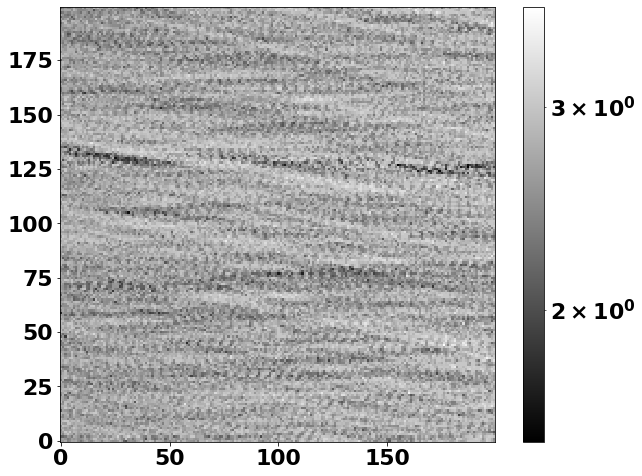

In [8]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=True)
shifts = D._calculate_shifts_from_known(object_name='2009 DE69', obs_code='500@-95')
for d in D.image_data.data:
    d -= unshifted_stack  
print(1)
'''
Shift+stack using the known (from Horizons + WCS) shifts.
'''
shiftss=shifts.copy()
print(2)
shifts[:,1]=shiftss[:,1]
shifts[:,0]=shiftss[:,0]
print(3)
D.integer_shift(shifts, padmean=True)
print(4)
D.stack(shifted=True, median_combine=True)
print(5)
D.save_stack(f'shift+stack_Tess_2009DE69_jpl{iii}.fits')
print(6)
#D.save_shifted('shift_Tess_2009DE69_jpl')
print(7)
xy0 = np.array([1342, 877]) - np.min(shifts,0).astype(int)
print(xy0)
xym = xy0 - 100
xyp = xy0 + 100
print(8)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
print(9)
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

0 2458438.4644670575
1 2458438.547801619
2 2458438.6311361487
3 2458438.7144706477
4 2458438.7978051156
5 2458438.881139552
6 2458438.9644739595
7 2458439.047808337
8 2458439.131142685
9 2458439.214477006
10 2458439.297811298
11 2458439.3811455634
12 2458439.4644798026
13 2458439.5478140153
14 2458439.6311482023
15 2458439.714482365
16 2458439.797816503
17 2458439.8811506163
18 2458439.964484707
19 2458440.047818774
20 2458440.131152818
21 2458440.2144868397
22 2458440.297820839
23 2458440.3811548166
24 2458440.4644887727
25 2458440.5478227073
26 2458440.631156621
27 2458440.7144905142
28 2458440.7978243865
29 2458440.8811582387
30 2458440.964492071
31 2458441.047825883
32 2458441.131159676
33 2458441.2144934493
34 2458441.2978272033
35 2458441.3811609377
36 2458441.464494654
37 2458441.5478283507
38 2458441.631162029
39 2458441.714495689
40 2458441.797829331
41 2458441.881162954
42 2458441.9644965595
43 2458442.0478301463
44 2458442.1311637154
45 2458442.2144972673
46 2458442.29783080

Saving to file shift_Tess_Dorothea_jpl_054.fits
Saving to file shift_Tess_Dorothea_jpl_055.fits
Saving to file shift_Tess_Dorothea_jpl_056.fits
Saving to file shift_Tess_Dorothea_jpl_057.fits
Saving to file shift_Tess_Dorothea_jpl_058.fits
Saving to file shift_Tess_Dorothea_jpl_059.fits
Saving to file shift_Tess_Dorothea_jpl_060.fits
Saving to file shift_Tess_Dorothea_jpl_061.fits
Saving to file shift_Tess_Dorothea_jpl_062.fits
Saving to file shift_Tess_Dorothea_jpl_063.fits
Saving to file shift_Tess_Dorothea_jpl_064.fits
Saving to file shift_Tess_Dorothea_jpl_065.fits
Saving to file shift_Tess_Dorothea_jpl_066.fits
Saving to file shift_Tess_Dorothea_jpl_067.fits
Saving to file shift_Tess_Dorothea_jpl_068.fits
Saving to file shift_Tess_Dorothea_jpl_069.fits
Saving to file shift_Tess_Dorothea_jpl_070.fits
Saving to file shift_Tess_Dorothea_jpl_071.fits
Saving to file shift_Tess_Dorothea_jpl_072.fits
Saving to file shift_Tess_Dorothea_jpl_073.fits
Saving to file shift_Tess_Dorothea_jpl_0

Saving to file shift_Tess_Dorothea_jpl_227.fits
Saving to file shift_Tess_Dorothea_jpl_228.fits
Saving to file shift_Tess_Dorothea_jpl_229.fits
Saving to file shift_Tess_Dorothea_jpl_230.fits
Saving to file shift_Tess_Dorothea_jpl_231.fits
Saving to file shift_Tess_Dorothea_jpl_232.fits
Saving to file shift_Tess_Dorothea_jpl_233.fits
Saving to file shift_Tess_Dorothea_jpl_234.fits
Saving to file shift_Tess_Dorothea_jpl_235.fits
Saving to file shift_Tess_Dorothea_jpl_236.fits
Saving to file shift_Tess_Dorothea_jpl_237.fits
Saving to file shift_Tess_Dorothea_jpl_238.fits
Saving to file shift_Tess_Dorothea_jpl_239.fits
Saving to file shift_Tess_Dorothea_jpl_240.fits
Saving to file shift_Tess_Dorothea_jpl_241.fits
Saving to file shift_Tess_Dorothea_jpl_242.fits
Saving to file shift_Tess_Dorothea_jpl_243.fits
Saving to file shift_Tess_Dorothea_jpl_244.fits
Saving to file shift_Tess_Dorothea_jpl_245.fits
Saving to file shift_Tess_Dorothea_jpl_246.fits
Saving to file shift_Tess_Dorothea_jpl_2

Peak count $\pm$ noise = 235.5 $\pm$  1.6 (148.2$\sigma$)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


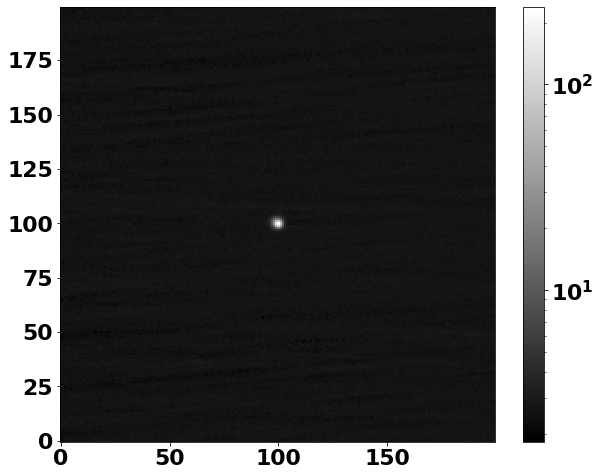

In [9]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess')
shifts = D._calculate_shifts_from_known(object_name='Dorothea', obs_code='500@-95')
for d in D.image_data.data:
    d -= unshifted_stack
'''
Shift+stack using the known (from Horizons + WCS) shifts.
'''
shiftss=shifts.copy()
shifts[:,1]=shiftss[:,1]
shifts[:,0]=shiftss[:,0]
D.integer_shift(shifts, padmean=True)
D.stack(shifted=True, median_combine=True)
D.save_stack('shift+stack_Tess_Dorothea_jpl.fits')
D.save_shifted('shift_Tess_Dorothea_jpl')
xy0 = np.array([1342, 877]) - np.min(shifts,0).astype(int)
print(xy0)
xym = xy0 - 100
xyp = xy0 + 100
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

0 2458438.4644670575
1 2458438.547801619
2 2458438.6311361487
3 2458438.7144706477
4 2458438.7978051156
5 2458438.881139552
6 2458438.9644739595
7 2458439.047808337
8 2458439.131142685
9 2458439.214477006
10 2458439.297811298
11 2458439.3811455634
12 2458439.4644798026
13 2458439.5478140153
14 2458439.6311482023
15 2458439.714482365
16 2458439.797816503
17 2458439.8811506163
18 2458439.964484707
19 2458440.047818774
20 2458440.131152818
21 2458440.2144868397
22 2458440.297820839
23 2458440.3811548166
24 2458440.4644887727
25 2458440.5478227073
26 2458440.631156621
27 2458440.7144905142
28 2458440.7978243865
29 2458440.8811582387
30 2458440.964492071
31 2458441.047825883
32 2458441.131159676
33 2458441.2144934493
34 2458441.2978272033
35 2458441.3811609377
36 2458441.464494654
37 2458441.5478283507
38 2458441.631162029
39 2458441.714495689
40 2458441.797829331
41 2458441.881162954
42 2458441.9644965595
43 2458442.0478301463
44 2458442.1311637154
45 2458442.2144972673
46 2458442.29783080

Saving to file shift_Tess_Sedna_jpl_060.fits
Saving to file shift_Tess_Sedna_jpl_061.fits
Saving to file shift_Tess_Sedna_jpl_062.fits
Saving to file shift_Tess_Sedna_jpl_063.fits
Saving to file shift_Tess_Sedna_jpl_064.fits
Saving to file shift_Tess_Sedna_jpl_065.fits
Saving to file shift_Tess_Sedna_jpl_066.fits
Saving to file shift_Tess_Sedna_jpl_067.fits
Saving to file shift_Tess_Sedna_jpl_068.fits
Saving to file shift_Tess_Sedna_jpl_069.fits
Saving to file shift_Tess_Sedna_jpl_070.fits
Saving to file shift_Tess_Sedna_jpl_071.fits
Saving to file shift_Tess_Sedna_jpl_072.fits
Saving to file shift_Tess_Sedna_jpl_073.fits
Saving to file shift_Tess_Sedna_jpl_074.fits
Saving to file shift_Tess_Sedna_jpl_075.fits
Saving to file shift_Tess_Sedna_jpl_076.fits
Saving to file shift_Tess_Sedna_jpl_077.fits
Saving to file shift_Tess_Sedna_jpl_078.fits
Saving to file shift_Tess_Sedna_jpl_079.fits
Saving to file shift_Tess_Sedna_jpl_080.fits
Saving to file shift_Tess_Sedna_jpl_081.fits
Saving to 

Saving to file shift_Tess_Sedna_jpl_249.fits
Done!
[1588 1118]


Peak count $\pm$ noise =  1.0 $\pm$  0.4 ( 2.9$\sigma$)

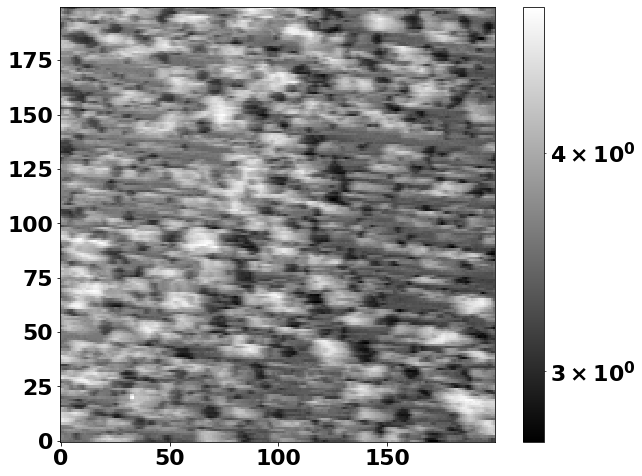

In [19]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess')
shifts = D._calculate_shifts_from_known(object_name='Sedna', obs_code='500@-95')
for d in D.image_data.data:
    d -= unshifted_stack
    d[unshifted_stack > np.median(unshifted_stack)+5] = 0
'''
Shift+stack using the known (from Horizons + WCS) shifts.
'''
shiftss=shifts.copy()
shifts[:,1]=shiftss[:,1]
shifts[:,0]=shiftss[:,0]
D.integer_shift(shifts, padmean=True)
D.stack(shifted=True, median_combine=False)
D.save_stack('shift+stack_Tess_Sedna_jpl.fits')
D.save_shifted('shift_Tess_Sedna_jpl')
xy0 = np.array([1543, 1103]) - np.min(shifts,0).astype(int)
print(xy0)
xym = xy0 - 100
xyp = xy0 + 100
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

[1103 1583]


Peak count $\pm$ noise =  1.2 $\pm$  0.4 ( 2.9$\sigma$)

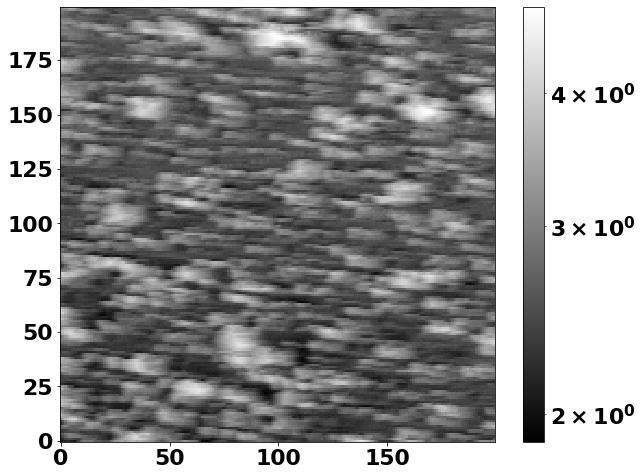

In [23]:
xy0 = np.array([1103, 1543]) - np.min(shifts,0).astype(int)
print(xy0)
xym = xy0 - 100
xyp = xy0 + 100
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

In [18]:
shifts.astype(int)

array([[  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,  -1],
       [  0,  -1],
       [  0,  -1],
       [  0,  -1],
       [  0,  -1],
       [  0,  -1],
       [  0,  -2],
       [  0,  -2],
       [  0,  -2],
       [  0,  -2],
       [  0,  -2],
       [  0,  -2],
       [  0,  -2],
       [  0,  -3],
       [  0,  -3],
       [  0,  -3],
       [  0,  -3],
       [  0,  -3],
       [  0,  -3],
       [  0,  -4],
       [  0,  -4],
       [  0,  -4],
       [  0,  -4],
       [  0,  -4],
       [  0,  -4],
       [  0,  -5],
       [  0,  -5],
       [  0,  -5],
       [  0,  -5],
       [  0,  -5],
       [  0,  -5],
       [  0,  -5],
       [  0,  -6],
       [  0,  -6],
       [  0,  -6],
       [  0,  -6],
       [  0,  -6],
       [  0,  -6],
       [  0,  -7],
       [  0,  -7],
       [  0,  -7],
       [  0,  -7],
       [  0,  -7],
       [  0,  -7],
       [  0,  -8],
       [  0,

In [9]:
'''
Get the EXPECTED thetas from the JPL Horizons ephemerides.
'''
from astroquery.jplhorizons import Horizons
# Query for reference time:
horizons_query0 = Horizons(id='sedna', location='568', epochs=time0, id_type='smallbody')
horizons_ephem0 = horizons_query0.ephemerides(extra_precision=False)
# Query for whole array of times:
horizons_query = Horizons(id='sedna', location='568', epochs=times, id_type='smallbody')
horizons_ephem = horizons_query.ephemerides(extra_precision=False)

latlon_expected = np.array(eq_to_ec(np.radians(horizons_ephem['RA']), np.radians(horizons_ephem['DEC']))).T
expected_thetas = np.array(ec_to_proj(*latlon_expected.T, *latlon0)).T
expected_thetas_asec = np.degrees(expected_thetas) * 3600
print(expected_thetas_asec)

[[ 1.30179310e+04 -5.23388975e+03]
 [ 1.29288968e+04 -5.24291589e+03]
 [ 1.28376274e+04 -5.25108031e+03]
 [ 1.27431380e+04 -5.25835283e+03]
 [ 1.26456911e+04 -5.26504852e+03]
 [ 1.25467840e+04 -5.27171461e+03]
 [ 1.24484155e+04 -5.27878641e+03]
 [ 1.23524389e+04 -5.28652041e+03]
 [ 1.22595309e+04 -5.29484310e+03]
 [ 1.21691640e+04 -5.30330768e+03]
 [ 1.20796278e+04 -5.31150454e+03]
 [ 1.19889396e+04 -5.31892724e+03]
 [ 1.18954763e+04 -5.32544279e+03]
 [ 1.17987368e+04 -5.33116277e+03]
 [ 1.16995713e+04 -5.33656771e+03]
 [ 1.15997949e+04 -5.34209069e+03]
 [ 1.15014752e+04 -5.34818354e+03]
 [ 1.14060244e+04 -5.35493386e+03]
 [ 1.13135583e+04 -5.36214599e+03]
 [ 1.12230517e+04 -5.36930085e+03]
 [ 1.11325424e+04 -5.37596938e+03]
 [ 1.10400606e+04 -5.38175738e+03]
 [ 1.09444396e+04 -5.38663053e+03]
 [ 1.08457584e+04 -5.39090095e+03]
 [ 1.07453802e+04 -5.39505131e+03]
 [ 1.06255590e+04 -5.40050836e+03]
 [ 1.05282830e+04 -5.40576680e+03]
 [ 1.04341929e+04 -5.41156979e+03]
 [ 1.03425640e+04 -5

In [10]:
horizons_ephem['RA'][0],horizons_ephem['DEC'][0]

(61.02088, 7.02201)

### Now with thetas/shifts calculated from ABG

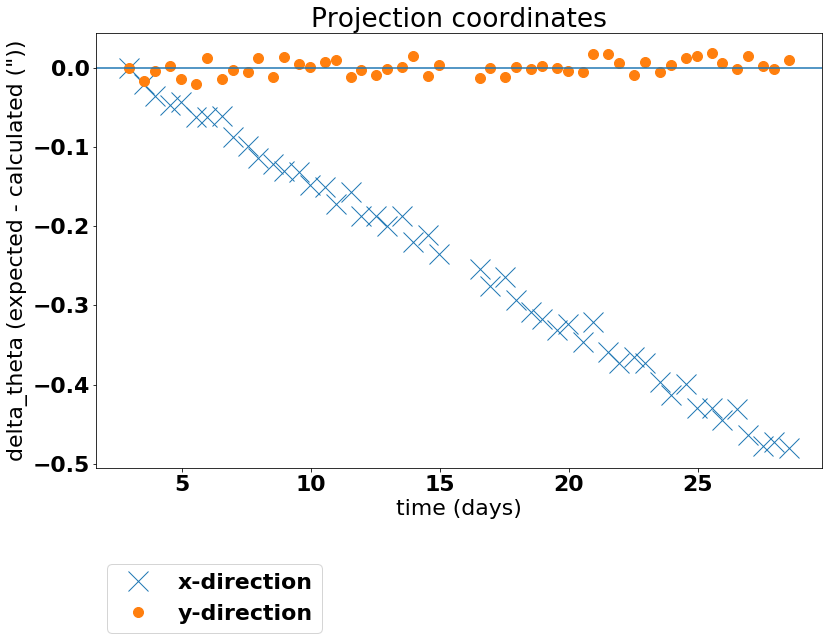

In [314]:
'''
Get the ecliptic position of the observer position. 
'''
# Observer's heliocentric ecliptic location at all times.
observer_helio_ecliptic = get_heliocentric_ecliptic_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_ecliptic0 = get_heliocentric_ecliptic_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_ecliptic_relative = observer_helio_ecliptic - observer_helio_ecliptic0

'''
Convert observer location to projection coordinate system, then convert abg to thetas.
'''
observer_projected = np.array([xyz_ec_to_proj(*obspos, *latlon0) for obspos in observer_helio_ecliptic_relative])
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected, GM=c.GM_sun.to('au**3/year**2').value)
# Convert to arcseconds
thetas_asec_foobar = np.degrees(thetas) * 3600 # radians to arc-sec
thetas_asec = thetas_asec_foobar - thetas_asec_foobar[0] + expected_thetas_asec[0]
#print(- thetas_asec_foobar[0] + expected_thetas_asec[0])
#print(thetas_asec)
plt.rcParams['figure.figsize'] = [13, 8]
dtimes_yr = (times-time0)
plt.plot(dtimes_yr, (expected_thetas_asec - thetas_asec)[:, 0], 'x', label='x-direction', ms=20)
plt.plot(dtimes_yr, (expected_thetas_asec - thetas_asec)[:, 1], '.', label='y-direction', ms=20)
plt.axhline(0)
plt.ylabel('delta_theta (expected - calculated ("))')
plt.xlabel('time (days)')
plt.title('Projection coordinates')
plt.legend(loc='center left', bbox_to_anchor=(0, -0.3))

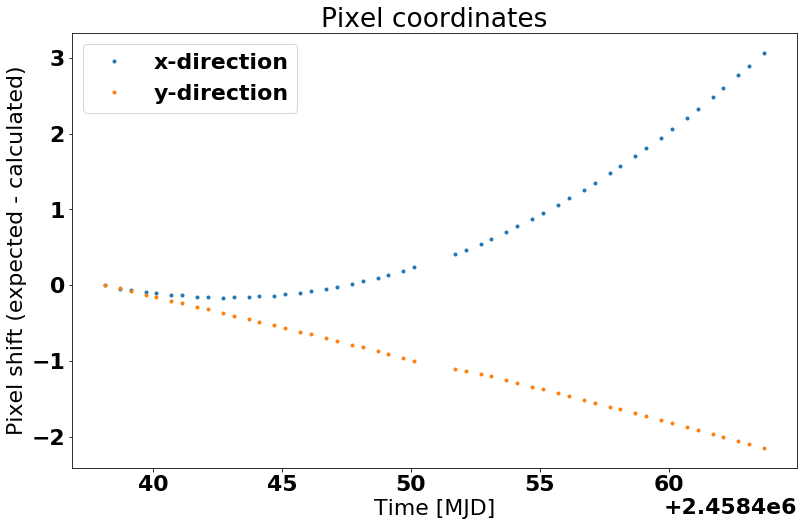

In [315]:
thetas_pixels = thetas_asec / 21  # This could be more accurate, but is pretty close. 

'''
Rotate thetas to CCD orientation
'''
proj2ccd_angle = np.radians(90) # ECL - np.radians(10)        # Could be whatever, depending on camera orientation
#proj2ccd_angle = ECL # - np.radians(10)        # Could be whatever, depending on camera orientation
rotmat = np.array([[np.cos(proj2ccd_angle), -np.sin(proj2ccd_angle)],
                   [np.sin(proj2ccd_angle), np.cos(proj2ccd_angle)]])
rotated = np.array([rotmat.dot(fi) for fi in thetas_pixels])
rotated -= rotated[0]

plt.plot(times, (shifts-rotated)[:, 0], '.', label='x-direction')
plt.plot(times, (shifts-rotated)[:, 1], '.', label='y-direction')
plt.xlabel('Time [MJD]')
plt.ylabel('Pixel shift (expected - calculated)')
plt.title('Pixel coordinates')
plt.legend()
plt.show()

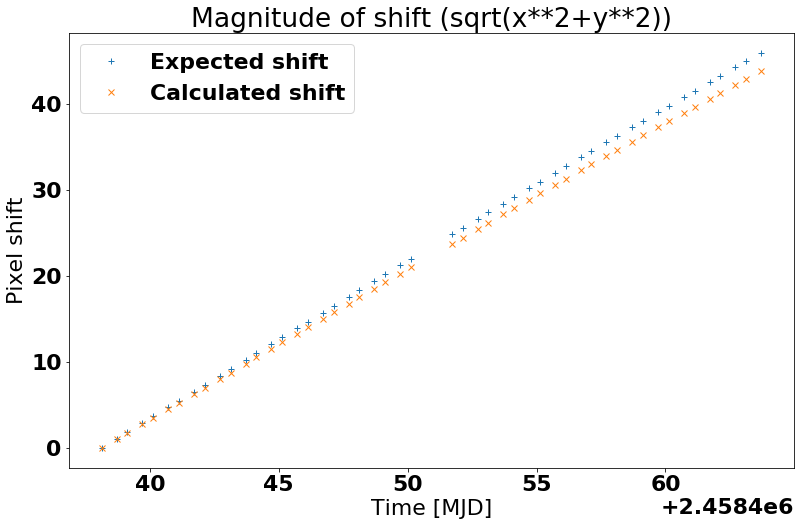

In [319]:
plt.plot(times, np.sum(shifts**2,1)**0.5, '+', label='Expected shift')
plt.plot(times, np.sum(rotated**2,1)**0.5, 'x', label='Calculated shift')
plt.xlabel('Time [MJD]')
plt.ylabel('Pixel shift')
plt.title('Magnitude of shift (sqrt(x**2+y**2))')
plt.legend()

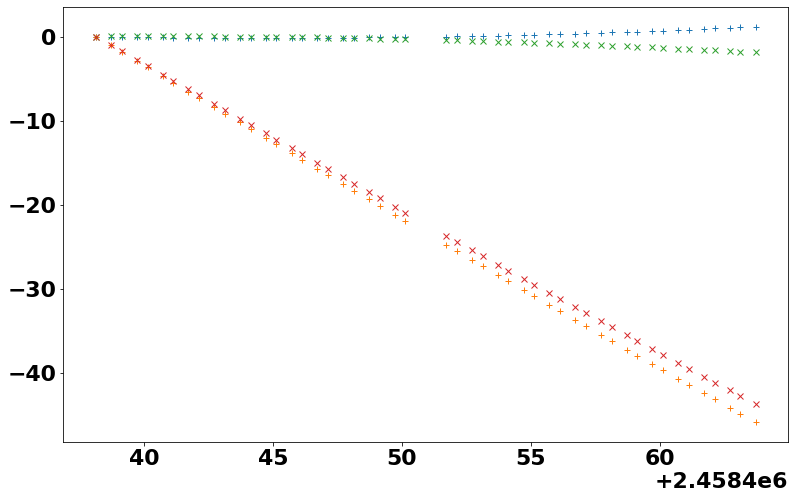

In [320]:
plt.plot(times,shifts,'+')
plt.plot(times,rotated,'x')

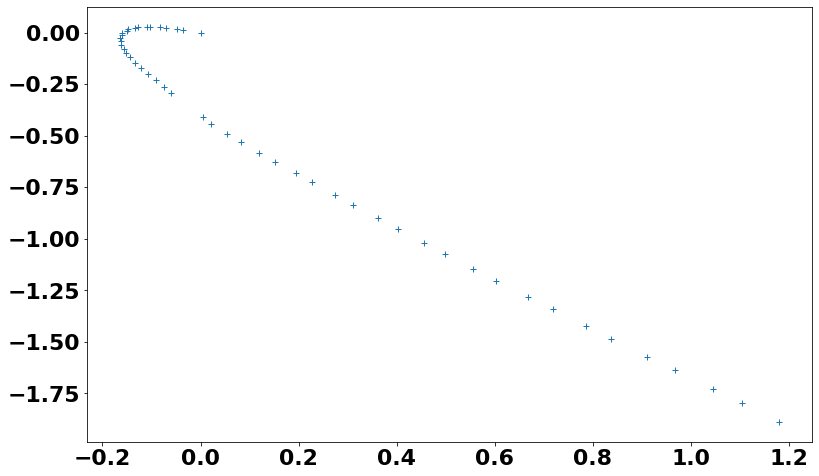

In [325]:
plt.plot(shifts[:,0],rotated[:, 0],'+')

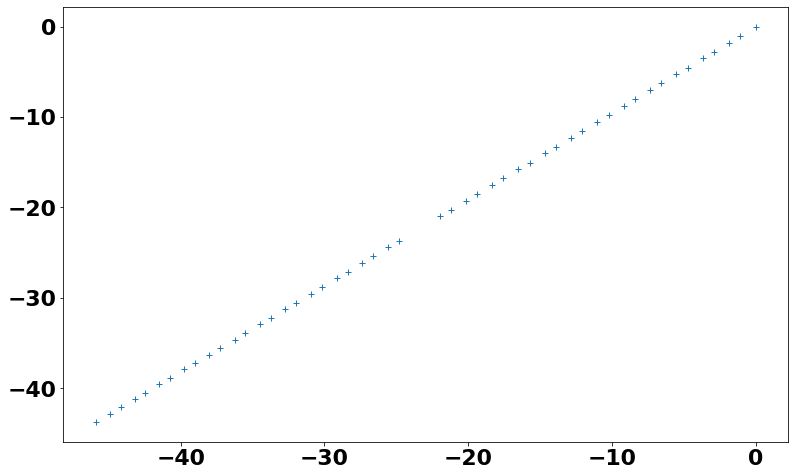

In [323]:
plt.plot(shifts[:,1],rotated[:, 1],'+')

Combining images using median stacking.


Peak count $\pm$ noise = 17.5 $\pm$  3.6 ( 4.9$\sigma$)

Saving to file shift+stack_Tess_Sedna_abg0.fits
Done!


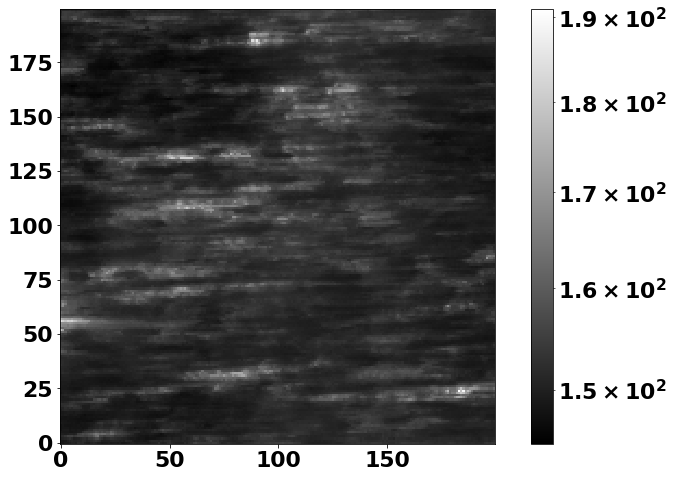

In [322]:
'''
Shift and stack using the calculated shifts.
'''
D.integer_shift(rotated, padmean=True)
D.stack(shifted=True, median_combine=True)
xy0 = np.array([1550, 1103])
xym = xy0 - 100
xyp = xy0 + 100
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))
D.save_stack('shift+stack_Tess_Sedna_abg0.fits')

### Acurately calculate CCD orientation & pixel scale
Since it seems the best-guess pixel scale and orientation seems just slightly off, let's calculate the actual orientation & scale. 

In [326]:
# Get centre pixel from WCS
CRPIX1 = D.image_data.header[0]['CRPIX1']
CRPIX2 = D.image_data.header[0]['CRPIX2']
# RA & Dec of centre pixel & then offset 100 pixels in each direction:
ra_CRPIX, dec_CRPIX = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1, CRPIX2, 1))
ra1, dec1 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1+100, CRPIX2, 1))
ra2, dec2 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1-100, CRPIX2, 1))
ra3, dec3 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1, CRPIX2+100, 1))
ra4, dec4 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1, CRPIX2-100, 1))

# delta_ra & delta_dec of the four offsets:
d1=np.array([(ra1-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec1)/2)), dec1-dec_CRPIX])
d2=np.array([(ra2-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec2)/2)), dec2-dec_CRPIX])
d3=np.array([(ra3-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec3)/2)), dec3-dec_CRPIX])
d4=np.array([(ra4-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec4)/2)), dec4-dec_CRPIX])

#Pixel scale:
pix_scale4 = (np.sum([d1 ** 2, d2 ** 2, d3 ** 2, d4 ** 2], 1)) ** 0.5 * 3600 / 100
pix_scale = np.array([np.mean(pix_scale4[0:2]), np.mean(pix_scale4[2:])])
print(f'Pixel scale (x-dir, y-dir) = {pix_scale}')

#angle between pixel grid and RA-Dec coordinates
angle = np.array([np.arctan2(d1[0], d1[1]) , np.arctan2(-d2[0], -d2[1]), 
                  np.arctan2(-d3[1], d3[0]), np.arctan2(d4[1], -d4[0])]) % (2*np.pi)
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[0]):8.4f}')
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[1]):8.4f}')
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[2]):8.4f}')
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[3]):8.4f}')

Pixel scale (x-dir, y-dir) = [21.05662012 20.57870413]
Angle acw between positive RA and positive x-axis of pixel grid: 259.2089
Angle acw between positive RA and positive x-axis of pixel grid: 259.3338
Angle acw between positive RA and positive x-axis of pixel grid:  80.1809
Angle acw between positive RA and positive x-axis of pixel grid:  80.1709


126.99999999999991


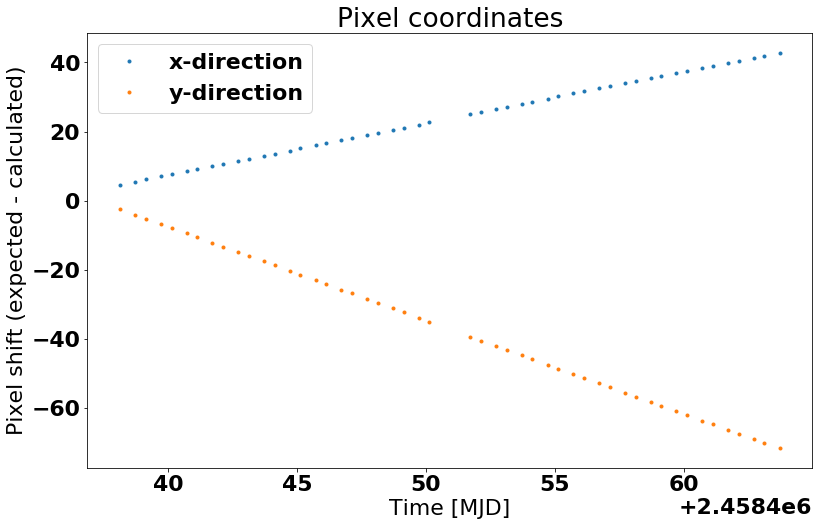

In [417]:
'''Shift+stack using the shift calculated from abg, using improved pixel scale & rotation.'''
D.integer_shift(shifts, padmean=True)

'''
Get the position of the observer position. 
'''
# Observer's heliocentric ecliptic location at all times.
observer_helio_ecliptic = get_heliocentric_ecliptic_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_ecliptic0 = get_heliocentric_ecliptic_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_ecliptic_relative = observer_helio_ecliptic - observer_helio_ecliptic0

'''
Convert observer location to projection coordinate system, then convert abg to thetas.
'''
observer_projected = np.array([xyz_ec_to_proj(*obspos, *latlon0) for obspos in observer_helio_ecliptic_relative])
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected)
# Convert to arcseconds
thetas_asec = np.degrees(thetas) * 3600  # radians to arc-sec
# Convert to pixels
#thetas_pixels = thetas_asec / 0.170      # This could be more accurate, but is pretty close. 
thetas_pixels = thetas_asec / pix_scale  #   based on calculation above

'''Rotate thetas to CCD orientation'''
proj2ccd_angle = ECL                          # Could be whatever, depending on camera orientation
i+=np.pi/180.
print(i*180/np.pi)
proj2ccd_angle = ECL + np.mean(i)   # Could be whatever, depending on camera orientation
'''
I'm actually confused here. Why do I need to add 180-angle rather than just subtracting the angle?
The positive X axis is ~180 degrees from the positive Dec axis, and Y+ is ~180 deg from RA+ axis, 
so shouldn't this be ECL-180? I feel like I have a sign wrong somewhere that is causing this... 
Like in the direction of how shifts are defined, or something. 
'''
rotmat = np.array([[np.cos(proj2ccd_angle), -np.sin(proj2ccd_angle)],
                   [np.sin(proj2ccd_angle), np.cos(proj2ccd_angle)]])
rotated = np.array([rotmat.dot(fi) for fi in thetas_pixels])

plt.plot(times, (shifts+rotated)[:, 0], '.', label='x-direction')
plt.plot(times, (shifts+rotated)[:, 1], '.', label='y-direction')
plt.xlabel('Time [MJD]')
plt.ylabel('Pixel shift (expected - calculated)')
plt.title('Pixel coordinates')
plt.legend()

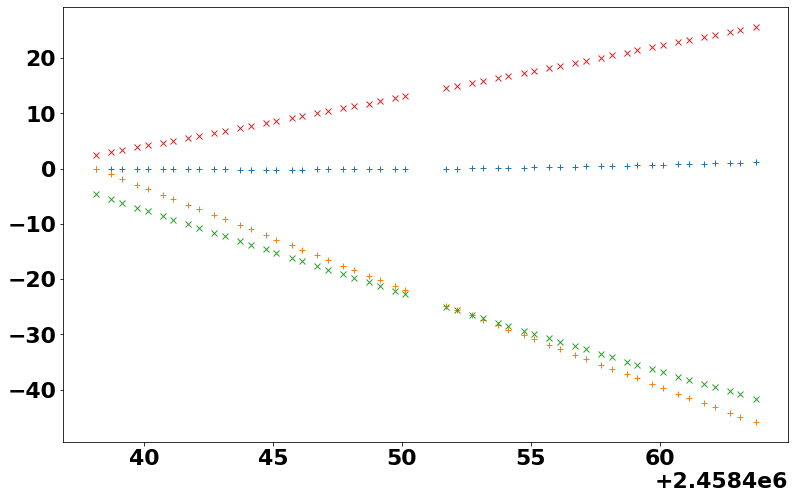

In [418]:
plt.plot(times,shifts,'+')
plt.plot(times,-rotated,'x')

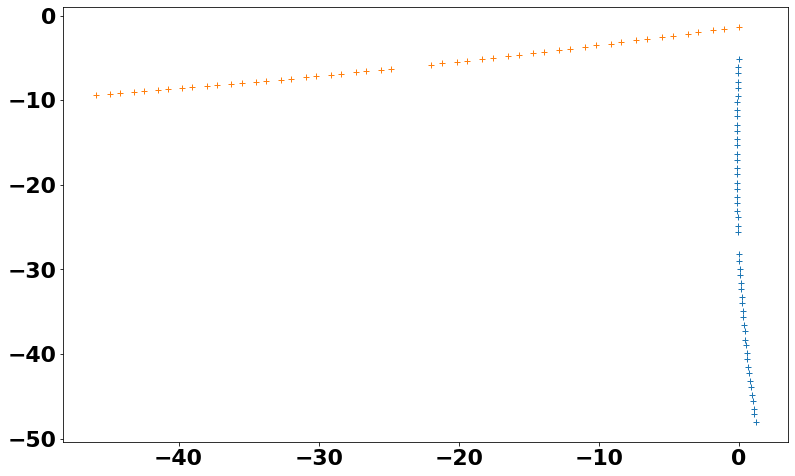

In [350]:
plt.plot(shifts[:,0],-rotated[:, 0],'+')
plt.plot(shifts[:,1],-rotated[:, 1],'+')

Combining images using median stacking.


Peak count $\pm$ noise =  9.7 $\pm$  3.9 ( 2.4$\sigma$)

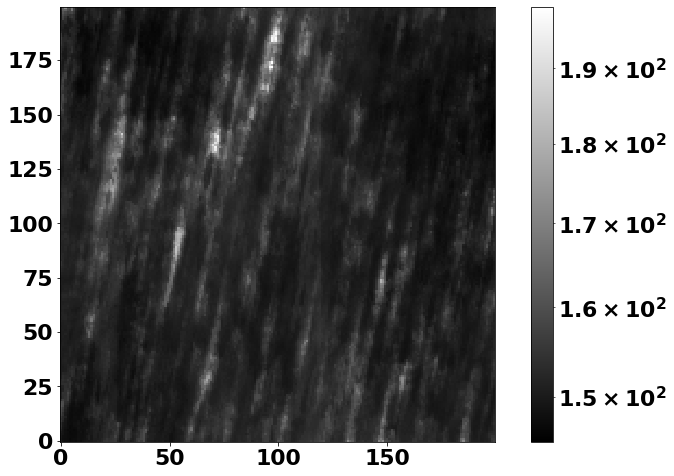

In [343]:
'''
Shift and stack using the calculated shifts.
'''
D.integer_shift(rotated, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

In [331]:
D.save_stack('shift+stack_Tess_Sedna_abg.fits')

Saving to file shift+stack_Tess_Sedna_abg.fits
Done!


In [ ]:
xy0

In [ ]:
xyp